In [1]:
import regex as re
import pandas as pd
import random
import requests
import urllib.request
from IPython.display import Image
#api de google sheets
from __future__ import print_function
import os.path
from bs4 import BeautifulSoup
import lxml.html
try:
    from googleapiclient.discovery import build
    from google_auth_oauthlib.flow import InstalledAppFlow
    from google.auth.transport.requests import Request
    from google.oauth2.credentials import Credentials
except:
    import sys
    !{sys.executable} -m pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
    from googleapiclient.discovery import build
    from google_auth_oauthlib.flow import InstalledAppFlow
    from google.auth.transport.requests import Request
    from google.oauth2.credentials import Credentials
try:
    from image import DrawImage
except:
    import sys
    !{sys.executable} -m pip install terminal-img
    from image import DrawImage

In [167]:
class Recomanador:
    
    def __init__(self):
        self.players = None
        self.dificultat = None
        self.dif_min = None
        self.dif_max = None
        self.temps = None
        
        
    
    def simple_questions(self):
        '''pregunta als jugadors: quants son, quina dificultat i quant de temps volen jugar'''
        while True:
            valid = False
            while valid == False:
                self.players = input('quants jugadors sou? ')
                if self.players.isnumeric():
                    self.players = int(self.players)
                    valid = True
            break

        while True:
            valid = False
            while valid == False:
                print('quina profunditat de joc esperes? Facil/Mitja/Dificil \n')
                self.dificultat = input('introdueix F,M o D ')
                if self.dificultat.upper() == 'F':
                    self.dificultat = self.dificultat.upper()
                    valid = True
                elif self.dificultat.upper() == 'M':
                    self.dificultat = self.dificultat.upper()
                    valid = True
                elif self.dificultat.upper() == 'D':
                    self.dificultat = self.dificultat.upper()
                    valid = True
            break

        if self.dificultat == 'F':
            self.dif_min = 0
            self.dif_max = 2.5
        elif self.dificultat == 'M':
            self.dif_min = 2
            self.dif_max = 3.5
        else:
            self.dif_min = 3.5
            self.dif_max = 5    

        while True:
            valid = False
            while valid == False:
                print('quanta estona voleu jugar aproximadament? ')
                self.temps = input('introdueix temps en minuts ')
                if self.temps.isnumeric():
                    self.temps = int(self.temps)
                    valid = True
            break
    
    
    def simple_choice(self,data):
        '''selecciona un joc, mostra una imatge si pot, i pregunta si va bé el joc seleccionat'''
        queried_jocs = data.query('min <= @self.players & max >= @self.players & Duració <= (@self.temps + 15) & Duració >= (@self.temps - 15) & Profunditat >= @self.dif_min & Profunditat <= @self.dif_max ')
        while True:
            
            # seleccionar juego al azar según criterios
            try:
                pick = random.choice(list(queried_jocs['Nom del joc']))
            except:
                print('no hi ha cap joc que cumpleixi els teus requisits\n')
                print("et recomanaré un joc a l'atzar\n")
                pick = random.choice(data['Nom del joc'])
            print(f' Perquè no jugueu a {pick} ?')
            
            # scrapeo de la imagen del juego
            try:
                # scrapeo de html para obtener la id del juego
                image = requests.get(f'https://www.boardgamegeek.com/search/boardgame?q={pick}&nosession=1&showcount=20', headers = {'user-agent': '{Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36}'})
                object_pattern = re.compile('/boardgame/([0-9]*)/')
                object_id = object_pattern.findall(image.text)[0]
                
                # scrapeo de api interna a partir de la id del juego
                resp = requests.get(f'https://api.geekdo.com/api/images?ajax=1&gallery=all&nosession=1&objectid={object_id}&objecttype=thing&pageid=1&showcount=36&size=thumb&sort=hot')
                # de las Imagenes recuperados seleccionamos una al azar de las 10 primeras
                image_url = resp.json()['images'][random.randint(0,10)]['imageurl_lg']
            except:
                print("No s'ha pogut trobar cap imatge del joc\n")
                image_url = None
            
            # scrapeo de ofertas
            
            resp2 = requests.get(f'https://api.geekdo.com/api/geekmarket/products?ajax=1&nosession=1&objectid={object_id}&objecttype=thing&pageid=1&showcount=10&stock=instock')
            
            for i in range(0,1):
                
                for j in resp2.json()['products'][i].items():
                    if j[0] == 'price':
                        print(j[1])
                    if j[0] == 'currency':
                        print(j[1])
                    
                    if j[0] == 'producthref':
                        print('\n Opción de compra: ')
                        url = 'https://www.boardgamegeek.com/' + j[1]
                        print(url)
                    
            # scrapeo de reseña 

            resp3 = requests.get('https://misutmeeple.com/resenas-list/')
            
            bs_obj = BeautifulSoup(resp3.content,'html.parser')
            
            tabla_rese = bs_obj.find('html').find('body').find('div', attrs={'class':'site'}).find('div', attrs={'class':'site-content'}).find('div', attrs={'class':'content-area'}).find('main').find('article').find('div').find('div').find('table')
            
            rese_ls = []
            for i in tabla_rese.find('tbody'):
                if not isinstance(i.find('a'),int):
                    rese_ls.append({
                        'juego':i.find('a').text,
                        'reseña': i.find('a').get('href')
                    })
            
            rese_df = pd.DataFrame(rese_ls)
            
            game_search2 = pick[1:-1]
            
            game_patt = re.compile(f'.*{game_search2}.*')
            
            not_found = True
            
            for i in range(0,len(rese_df['juego'])):
                if pick.upper()  == (rese_df.iloc[i,0].upper()):
                    print('\n Reseña del juego: ')
                    print(rese_df.iloc[i,0])
                    print(rese_df.iloc[i,1])
                    not_found = False
            
            if not_found:
                for i in range(0,len(rese_df['juego'])):
                    if len(game_patt.findall(rese_df.iloc[i,0])) > 0:
                        print(rese_df.iloc[i,0])
                        print(rese_df.iloc[i,1])
                        not_found = False
                        break
            
            if not_found:
                print('no se encontró ninguna reseña para este juego')
            
            # mostrar imagen en jupyter
            if image_url != None:
                
                try:
                    display(Image(image_url))
                except:
                    print('No es pot mostrar la imatge')
            

            agree = input("T'agrada aquesta opció? Y/N ")
            if agree.upper() == 'Y':
                break

In [168]:
class JocDB:
    
    def __init__(self):
        self.jocs_list = []
        self.jocs_df = None
        
    
    def apiCall(self):
        '''usa la api de google sheets per recuperar la informació de la meva colecció'''
        # obtenim la jocs de taula sheet desded l'Api de google

        # If modifying these scopes, delete the file token.json.
        SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

        # The ID and range of a sample spreadsheet.
        SAMPLE_SPREADSHEET_ID = '1Ixtc7aIaMxe8XeKQC9fAfBerZxYFsifS0sy0X2yJfB4'
        SAMPLE_RANGE_NAME = 'Jocs - Gerard and Cris!A1:O222'

        creds = None
            # The file token.json stores the user's access and refresh tokens, and is
            # created automatically when the authorization flow completes for the first
            # time.
        if os.path.exists('token.json'):
            creds = Credentials.from_authorized_user_file('token.json', SCOPES)
        # If there are no (valid) credentials available, let the user log in.
        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())
            else:
                flow = InstalledAppFlow.from_client_secrets_file(
                    'credentials.json', SCOPES)
                creds = flow.run_local_server(port=0)
            # Save the credentials for the next run
            with open('token.json', 'w') as token:
                token.write(creds.to_json())
        service = build('sheets', 'v4', credentials=creds)

        # Call the Sheets API
        print('retrieving boardgame collection from google sheets...')
        sheet = service.spreadsheets()
        result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                    range=SAMPLE_RANGE_NAME
                                   ).execute()
        values = result.get('values', [])
        self.jocs_list = values
        
    def toDf(self):
        '''transforma la informació obtinguda en un dataframe'''
        # creem a mà un Dataframe accedint a les llistes com si fosin columnes
        self.jocs_df = pd.DataFrame({'Nom del joc':[self.jocs_list[i][1] for i in range(3,len(self.jocs_list))],
                                     'Num. Jugadors':[self.jocs_list[i][2] for i in range(3,len(self.jocs_list))],
                                      'Gènere':[self.jocs_list[i][3] for i in range(3,len(self.jocs_list))],
                                      'Millor a 2?':[self.jocs_list[i][4] for i in range(3,len(self.jocs_list))],
                                      "Dificultat d'aprenentatge (sobre 5)":[self.jocs_list[i][5] for i in range(3,len(self.jocs_list))],
                                      'Profunditat':[float(self.jocs_list[i][6]) for i in range(3,len(self.jocs_list))],
                                      'Duració':[int(self.jocs_list[i][8]) for i in range(3,len(self.jocs_list))]
                                     })
        
        # continuem tractant el df
        minjoc = re.compile('([1-9]) a [1-9]')
        maxjoc = re.compile('[1-9] a ([1-9])')
        
        # creem noves columnes amb el min i el max
        for i in self.jocs_df['Num. Jugadors'].index:
            min_p = minjoc.findall(self.jocs_df.loc[i,'Num. Jugadors'])
            if len(min_p) > 0:
                min_p = int(min_p[0])
                self.jocs_df.loc[i,'min'] = min_p
            else:
                self.jocs_df.loc[i,'min'] = 0
            max_p = maxjoc.findall(self.jocs_df.loc[i,'Num. Jugadors'])
            if len(max_p) > 0:
                max_p = int(max_p[0])
                self.jocs_df.loc[i,'max'] = max_p
            else:
                self.jocs_df.loc[i,'max'] = 0
            
        #jocs només per un numero fix de persones
        for i in self.jocs_df['Num. Jugadors'].index:
            if self.jocs_df.loc[i,'min'] == 0:
                self.jocs_df.loc[i,'min'] = int(self.jocs_df.loc[i,'Num. Jugadors'])
                self.jocs_df.loc[i,'max'] = int(self.jocs_df.loc[i,'Num. Jugadors'])
       


In [169]:
def main():
    # creem la conexió
    coleccio = JocDB()
    try:
        coleccio.apiCall()
    except:
        raise 'Conexió amb API ha fallat'
    
    # transformem a DataFrame
    coleccio.toDf()
    game_df = coleccio.jocs_df
    
    # creem el recomanador
    recom = Recomanador()
    recom.simple_questions()
    recom.simple_choice(game_df)

retrieving boardgame collection from google sheets...
quants jugadors sou? 4
quina profunditat de joc esperes? Facil/Mitja/Dificil 

introdueix F,M o D m
quanta estona voleu jugar aproximadament? 
introdueix temps en minuts 60
 Perquè no jugueu a 1923: Cotton club ?

 Opción de compra: 
https://www.boardgamegeek.com//geekmarket/product/2684381
40.00
EUR
no se encontró ninguna reseña para este juego


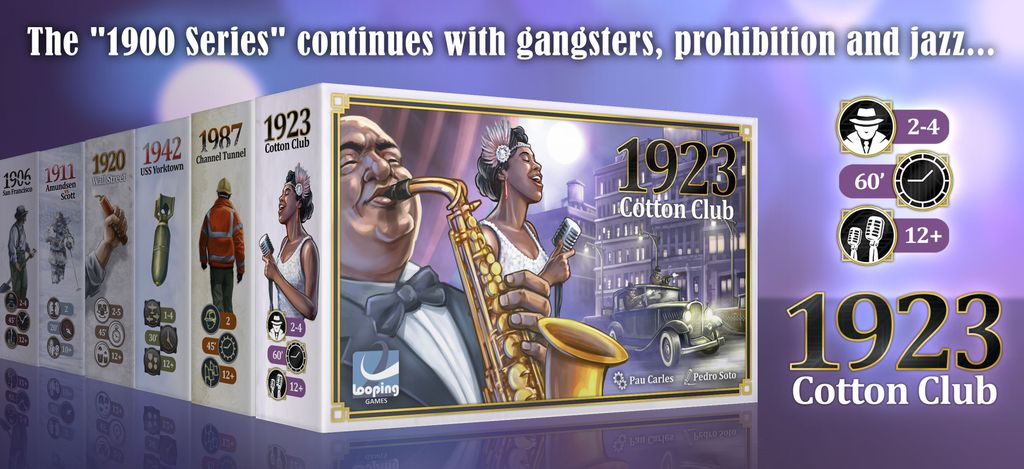

T'agrada aquesta opció? Y/N n
 Perquè no jugueu a La Isla ?

 Opción de compra: 
https://www.boardgamegeek.com//geekmarket/product/2700293
15.00
EUR

 Reseña del juego: 
La Isla
https://misutmeeple.com/2018/01/resena-la-isla/


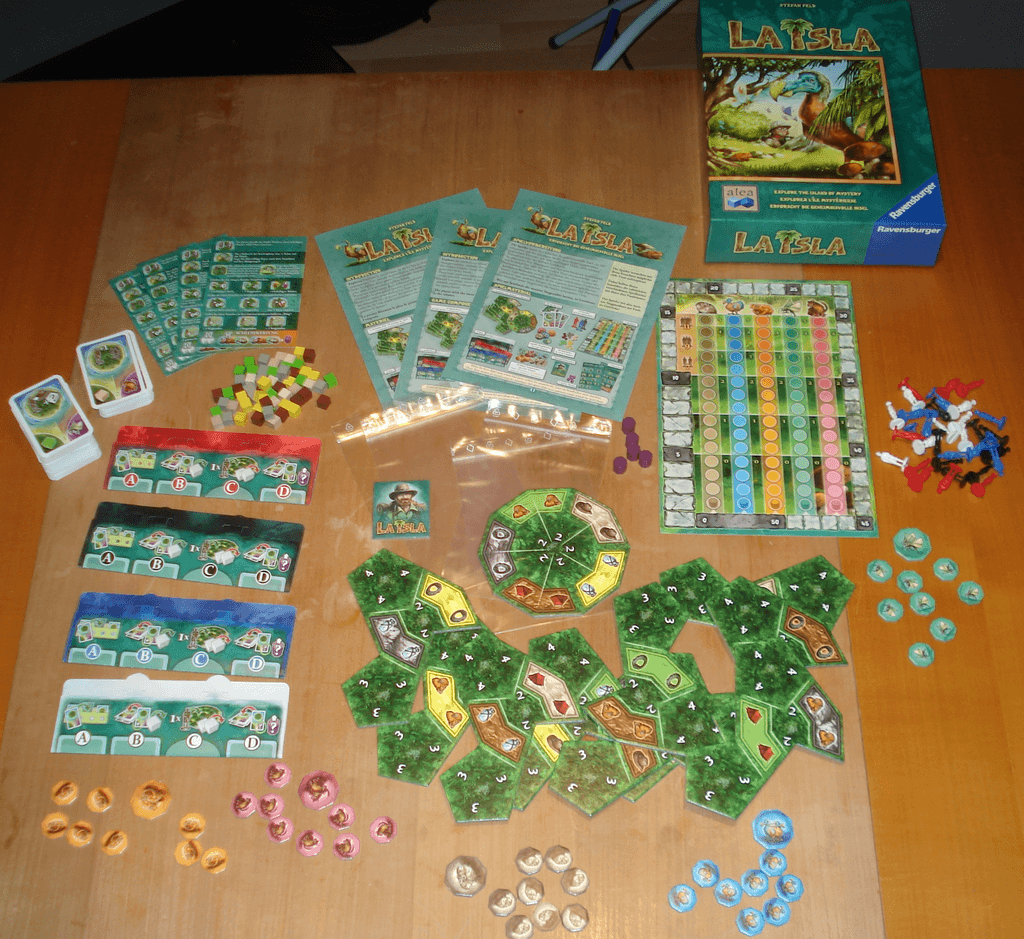

T'agrada aquesta opció? Y/N y


In [170]:
main()

In [5]:
resp = requests.get('https://www.boardgamegeek.com/boardgame/339614/', headers = {'user-agent': '{Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36}'})

In [6]:
bs_obj = BeautifulSoup(resp.content,'html.parser')

In [30]:
resp2 = requests.get('https://api.geekdo.com/api/geekmarket/products?ajax=1&nosession=1&objectid=339614&objecttype=thing&pageid=1&showcount=10&stock=instock')


In [35]:
resp2.json()

{'linkeditem': {'type': 'things',
  'id': '339614',
  'name': 'Shinkansen: Zero Kei',
  'href': '/boardgame/339614/shinkansen-zero-kei',
  'label': 'Board Game',
  'labelpl': 'Board Games',
  'hasAngularLink': False,
  'descriptors': [{'name': 'yearpublished', 'displayValue': '2021'},
   {'name': 'rank', 'displayValue': 'Rank 7729'}],
  'imageid': 6218277,
  'imageSets': {'square100': {'src': 'https://cf.geekdo-images.com/ckJBBedoqcSyIN-gGX39kw__square100/img/EqYpEVdnVqAyo7vZ3LFeiKUr0CE=/0x942:2307x3249/100x100/filters:strip_icc()/pic6218277.png',
    'src@2x': 'https://cf.geekdo-images.com/ckJBBedoqcSyIN-gGX39kw__square100@2x/img/Uca8Hy9uNEAahimerGh3YkfpAwI=/0x942:2307x3249/200x200/filters:strip_icc()/pic6218277.png'}},
  'image': {'type': 'images',
   'id': '6218277',
   'dimensions': {'width': 2307, 'height': 3249},
   'imageid': 6218277,
   'caption': 'Game cover',
   'postdate': '2021-06-08T15:17:45+00:00',
   'gallery': 'game',
   'uploader': 194915,
   'extension': 'png',
   'bl

In [67]:
### Conseguir url para comprar
top3 = 0
for i in range(0,len(resp2.json()['products'])):
    count = 0
    top3 += 1
    for j in resp2.json()['products'][i].items():
        if j[0] == 'price':
            print(j[1])
        if j[0] == 'currency':
            print(j[1])
        
        if j[0] == 'producthref':
            url = 'https://www.boardgamegeek.com/' + j[1]
            print(url)
        
        #print(price,' ',currency,' ',url)
        
        
    if top3 == 3:
        break

https://www.boardgamegeek.com//geekmarket/product/2700503
30.00
EUR
https://www.boardgamegeek.com//geekmarket/product/2686566
29.00
EUR
https://www.boardgamegeek.com//geekmarket/product/2680398
34.99
EUR


In [151]:
# buscar reseña 

resp3 = requests.get('https://misutmeeple.com/resenas-list/')

bs_obj = BeautifulSoup(resp3.content,'html.parser')

tabla_rese = bs_obj.find('html').find('body').find('div', attrs={'class':'site'}).find('div', attrs={'class':'site-content'}).find('div', attrs={'class':'content-area'}).find('main').find('article').find('div').find('div').find('table')

rese_ls = []
for i in tabla_rese.find('tbody'):
    if not isinstance(i.find('a'),int):
        rese_ls.append({
            'juego':i.find('a').text,
            'reseña': i.find('a').get('href')
        })

rese_df = pd.DataFrame(rese_ls)

game_search = 'Shinkansen'

game_search2 = game_search[1:-1]

game_patt = re.compile(f'.*{game_search2}.*')

for i in range(0,len(rese_df['juego'])):
    if len(game_patt.findall(rese_df.iloc[i,0])) > 0:
        print(rese_df.iloc[i,0])
        print(rese_df.iloc[i,1])
    

Shinkansen Zero-Kei
https://misutmeeple.com/2021/10/resena-shinkansen-zero-kei/


In [ ]:
bs_obj.find_all('div').find()

In [68]:
'''
top3 = 0
for i in range(0,len(resp2.json()['products'])):
    count = 0
    top3 += 1
    for j in resp2.json()['products'][i].items():
        count += 1
        print(f'{count} ', j)
    if top3 == 3:
        break
'''
    

"\ntop3 = 0\nfor i in range(0,len(resp2.json()['products'])):\n    count = 0\n    top3 += 1\n    for j in resp2.json()['products'][i].items():\n        count += 1\n        print(f'{count} ', j)\n    if top3 == 3:\n        break\n"